Based on Blog "Learn how to teach your computer to Chemistry: Free Chemception models with RDKit and Keras" by Esben Jannik Bjerrum who recreated Free "Chemception" models

From https://www.wildcardconsulting.dk/useful-information/learn-how-to-teach-your-computer-to-see-chemistry-free-chemception-models-with-rdkit-and-keras/

"Chemception": by Garrett Goh and coworkers https://arxiv.org/abs/1706.06689 and https://arxiv.org/abs/1710.02238 where the authors used encoded images for reading in molecules into these deep neural networks designed for image recognition. 

In [1]:
from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem, PandasTools

import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline
print("RDKit: %s"%rdkit.__version__)

c:\users\takedatn\appdata\local\continuum\anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


RDKit: 2017.09.3


In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("Keras: %s"%keras.__version__)

Using TensorFlow backend.


Keras: 2.1.5


In [3]:
data = pd.read_csv('SAMPL.csv')

In [4]:
data.shape

(642, 4)

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 642 entries, 0 to 641
Data columns (total 4 columns):
iupac     642 non-null object
smiles    642 non-null object
expt      642 non-null float64
calc      642 non-null float64
dtypes: float64(2), object(2)
memory usage: 20.1+ KB


In [6]:
data['mol'] = data["smiles"].apply(Chem.MolFromSmiles)

80 x 80 grid, where each pixel had a resolution of 0.5 Å: embed=20.0, res=0.5
Gasteiger charges are calculated and the 2D drawing coordinates computed.
encode the molecule into an “image”

In [7]:
def chemcepterize_mol(mol, embed=20.0, res=0.5):
    dims = int(embed*2/res)
    cmol = Chem.Mol(mol.ToBinary())
    cmol.ComputeGasteigerCharges()
    AllChem.Compute2DCoords(cmol)
    coords = cmol.GetConformer(0).GetPositions()
    vect = np.zeros((dims,dims,4)) ## vacuum,  shape(image_width, image_height,4 channels)
    #Bonds first layer, encoded the bondorder
    for i,bond in enumerate(mol.GetBonds()):
        bondorder = bond.GetBondTypeAsDouble()
        bidx = bond.GetBeginAtomIdx()
        eidx = bond.GetEndAtomIdx()
        bcoords = coords[bidx]
        ecoords = coords[eidx]
        frac = np.linspace(0,1,int(1/res*2)) #
        for f in frac:
            c = (f*bcoords + (1-f)*ecoords)
            idx = int(round((c[0] + embed)/res))
            idy = int(round((c[1]+ embed)/res))
            #Save in the vector first channel
            vect[ idx , idy ,0] = bondorder
    #Atom Layers
    for i,atom in enumerate(cmol.GetAtoms()):
            idx = int(round((coords[i][0] + embed)/res))
            idy = int(round((coords[i][1]+ embed)/res))
            #Atomic number :2nd layer
            vect[ idx , idy, 1] = atom.GetAtomicNum()
            #Gasteiger Charges :3rd layer
            charge = atom.GetProp("_GasteigerCharge")
            vect[ idx , idy, 3] = charge
            #Hybridization : 4th layer
            hyptype = atom.GetHybridization().real
            vect[ idx , idy, 2] = hyptype
    return vect

Show a “chemcepterized” molecule as an image. 

(100, 100, 4)


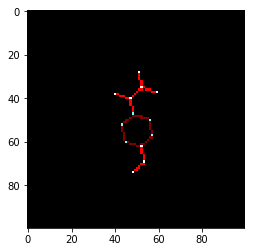

In [8]:
mol = data["mol"][0]
v = chemcepterize_mol(mol, embed=10, res=0.2)
print(v.shape)
plt.imshow(v[:,:,:3])

“Chemcepterize” the entire collection of molecules and add a new column with the “images” to the dataframe, 48 x 48 

In [9]:
def vectorize(mol):
    return chemcepterize_mol(mol, embed=12)
data["molimage"] = data["mol"].apply(vectorize)

Split The dataset to a train or test set.

In [13]:
assay = "expt" ##experimental data solvation free energy
X_train, X_test, y_train, y_test= train_test_split(data["molimage"],data[assay],train_size=0.9, test_size=0.1,random_state=42)
print(X_train.shape)
print(X_test.shape)

(577,)
(65,)


In [14]:
y_train.shape

(577,)

In [15]:
X_train=np.array(list(X_train))
print(X_train.shape)

(577, 48, 48, 4)


In [16]:
X_test=np.array(list(X_test))
print(X_test.shape)

(65, 48, 48, 4)


In [17]:
y_train=y_train.values.reshape(-1,1)
y_test=y_test.values.reshape(-1,1)

In [31]:
y_train[0:5]

array([[-4.59],
       [-2.87],
       [-5.  ],
       [ 2.97],
       [-4.2 ]])

Scale the data to somewhat between -1 and 1 (neural networks like this range and it makes training somewhat easier)

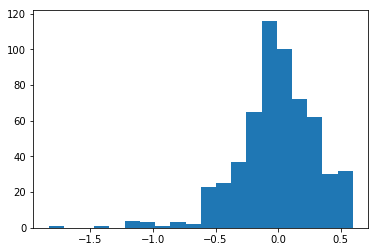

In [18]:
from sklearn.preprocessing import RobustScaler
rbs = RobustScaler(with_centering=True, with_scaling=True, quantile_range=(5.0, 95.0), copy=True)
y_train_s = rbs.fit_transform(y_train)
y_test_s = rbs.transform(y_test)
h = plt.hist(y_train_s, bins=20)

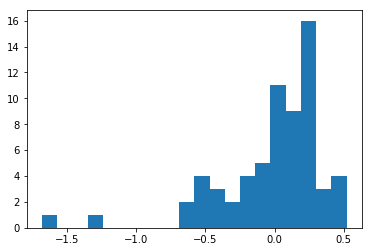

In [19]:
h = plt.hist(y_test_s, bins=20)

In [20]:
np.save('X_train_FSolv_48', X_train)
np.save('X_test_FSolv_48', X_test)
np.save('y_train_FSolv_48', y_train_s)
np.save('y_test_FSolv_48', y_test_s)

Build the chemception network.
Template model used for the development of our Chemception architecture :Inception-ResNet.v2


In [33]:
input_shape = X_train.shape[1:]
print(input_shape)

(80, 80, 4)


In [36]:
def Inception0(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
 
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

In [37]:
def Inception(input):
    tower_1 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_1 = Conv2D(16, (3, 3), padding='same', activation='relu')(tower_1)
 
    tower_2 = Conv2D(16, (1, 1), padding='same', activation='relu')(input)
    tower_2 = Conv2D(16, (5, 5), padding='same', activation='relu')(tower_2)
 
    tower_3 = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    tower_3 = Conv2D(16, (1, 1), padding='same', activation='relu')(tower_3)
 
    output = keras.layers.concatenate([tower_1, tower_2, tower_3], axis=-1)
    return output

In [38]:
input_img = Input(shape=input_shape)
 
x = Inception0(input_img) ## no MaxPooling
x = Inception(x)
x = Inception(x)
od=int(x.shape[1])
x = MaxPooling2D(pool_size=(od,od), strides=(1,1))(x)
x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output = Dense(1, activation='linear')(x)  ## aiming at a regression model so using "linear"
 
model = Model(inputs=input_img, outputs=output)
 
print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 80, 80, 4)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 80, 80, 16)   80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 80, 80, 16)   80          input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 80, 80, 16)   2320        conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [36]:
optimizer = Adam(lr=0.00025)
model.compile(loss="mse", optimizer=optimizer)

Augmenting data

In [37]:
from keras.preprocessing.image import ImageDataGenerator

generator = ImageDataGenerator(rotation_range=180,
                               width_shift_range=0.1,height_shift_range=0.1,
                               fill_mode="constant",cval = 0,
                               horizontal_flip=True, vertical_flip=True,data_format='channels_last',
                            
                               )
 
#Concatenate for longer epochs
Xt = np.concatenate([X_train]*50, axis=0)
yt = np.concatenate([y_train_s]*50, axis=0)
 
batch_size=128
g = generator.flow(Xt, yt, batch_size=batch_size, shuffle=True)
steps_per_epoch = 10000/batch_size

Training.  
ReduceLROnPlateau callback : To lower the learning rate once the validation loss starts to plateau off

In [ ]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,patience=10, min_lr=1e-6, verbose=1)
history = model.fit_generator(g,
                              steps_per_epoch=len(Xt)//batch_size,
                              epochs=150,
                              validation_data=(X_test,y_test_s),
                              callbacks=[reduce_lr])

Epoch 1/50
91/91 [==============================] - 761s 8s/step - loss: 0.1103 - val_loss: 0.1336

See the convergence of the training

In [35]:
name = "Chemception_std_notebook_demo"
model.save("%s.h5"%name)
 
hist = history.history
import pickle

In [36]:
file=open("%s_history.pickle"%name,"wb")

In [37]:
pickle.dump(hist, file)

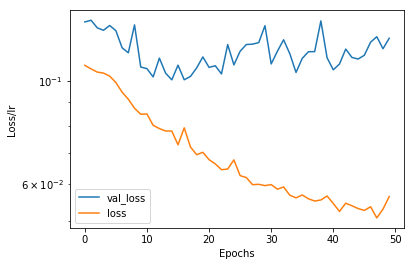

In [38]:
for label in ['val_loss','loss']:
    plt.plot(hist[label], label = label)
plt.legend()
plt.yscale("log")
plt.xlabel("Epochs")
plt.ylabel("Loss/lr")

Evaluating the performance

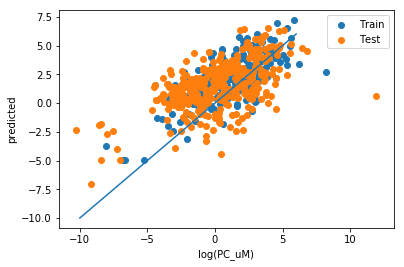

In [40]:
y_pred_t = rbs.inverse_transform(model.predict(X_train))
y_pred = rbs.inverse_transform(model.predict(X_test))
plt.scatter(np.log(y_train_3), y_pred_t, label="Train")
plt.scatter(np.log(y_test_3), y_pred, label="Test")
plt.xlabel("log(PC_uM)")
plt.ylabel("predicted")
plt.plot([-10,6],[-10,6])
plt.legend()

In [42]:
corr2 = np.corrcoef(np.log(y_test_3).reshape(1,-1), y_pred.reshape(1,-1))[0][1]**2
rmse = np.mean((np.log(y_test_3) - y_pred)**2)**0.5
print("R2 : %0.2F"%corr2)
print("RMSE : %0.2F"%rmse)

R2 : 0.33
RMSE : 2.71


Take an example molecule and plot some of the outputs from the different layers

In [43]:
molnum = 143
molimage = np.array(list(data["molimage"][molnum:molnum+1]))
mol = data["mol"][molnum]

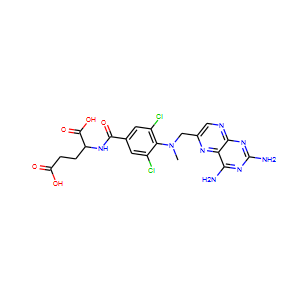

In [44]:
from rdkit.Chem import Draw
Draw.MolToImage(mol)

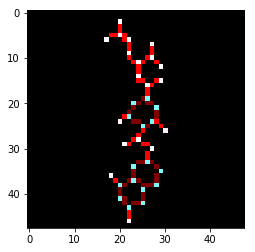

In [45]:
plt.imshow(molimage[0,:,:,:3])

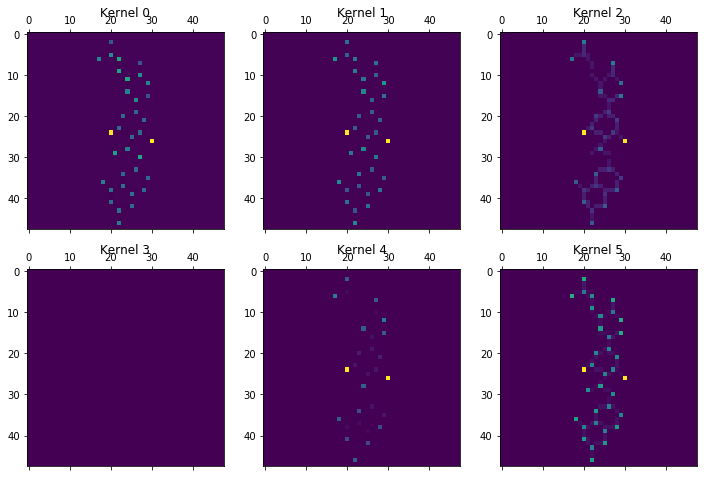

In [46]:
layer1_model = Model(inputs=model.input,
                    outputs=model.layers[2].output)
 
kernels1 = layer1_model.predict(molimage)[0]
 
def plot_kernels(kernels):
    fig, axes = plt.subplots(2,3, figsize=(12,8))
    for i,ax in enumerate(axes.flatten()):
        ax.matshow(kernels[:,:,i])
        ax.set_title("Kernel %s"%i)
 
plot_kernels(kernels1)

Layer 7


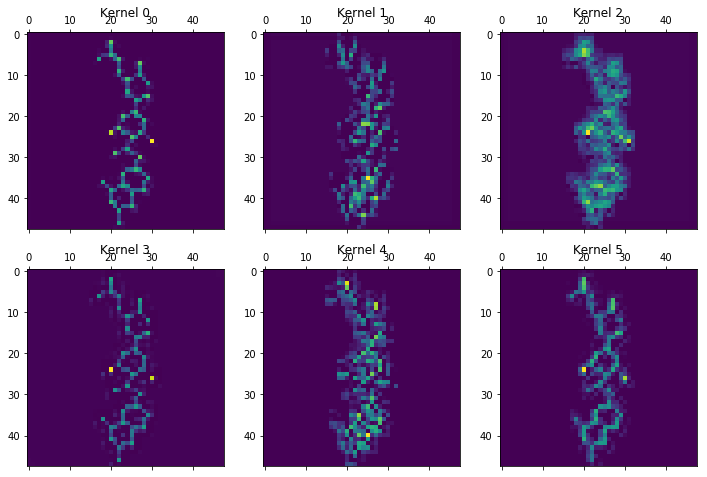

Layer 13


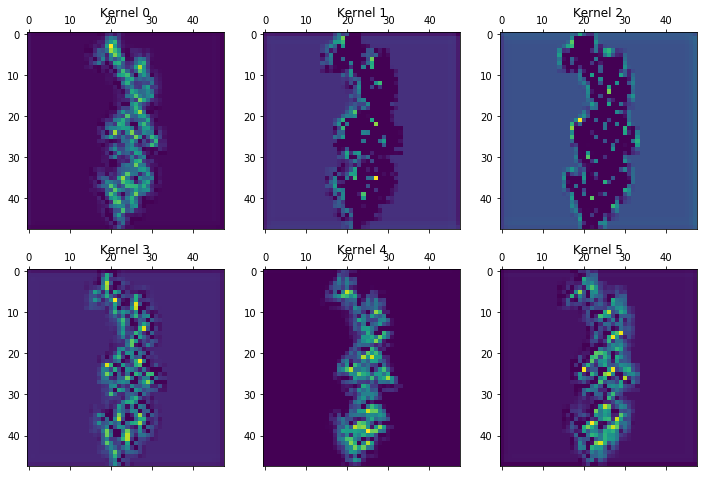

Layer 15


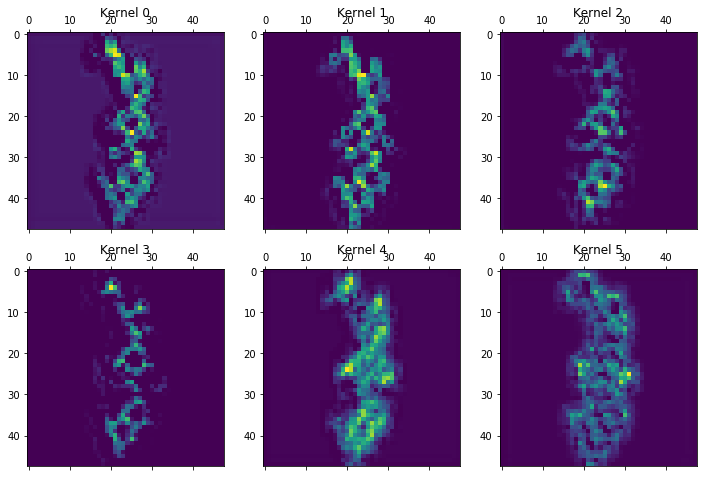

Layer 19


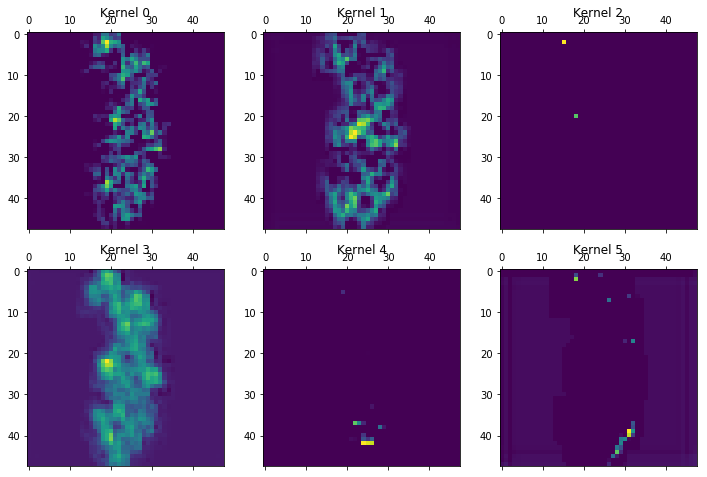

Layer 20


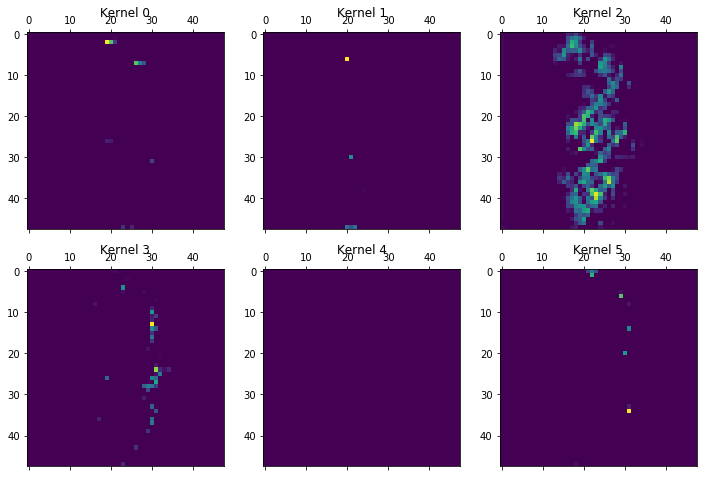

In [47]:
for layer in [7,13,15,19,20]:
    print("Layer %i"%layer)
    plot_kernels(Model(inputs=model.input,outputs=model.layers[layer].output).predict(molimage)[0])
    plt.show()